# Crypto Pairs Trading
### by Kevin Wang

During the summer after my sophomore year, I worked on a crytocurrency pairs trading project. Here is my work from the summer as well as my backtesting results.

---
## Pairs Trading

Suppose we have two non-stationary time series $x_t$ and $y_t$. The two series are said to be cointegrated if the time series 

$$y_t - \beta x_t$$

is stationary for some value $\beta$. In other words, deviations from the long-run equilibrium are caused by white noise, and will be subsequently corrected in future time steps. Pairs trading exploits the mean-reverting behavior of cointegrated stocks. 

Suppose we have two assets $\mathbf{A}$ and $\mathbf{B}$. Let $\log{p_t^A}$ represent the log price of $\mathbf{A}$ at time $t$, and let $\log{p_t^B}$ be defined the same for $\mathbf{B}$. Logarithms are used because we care about the percent change of an asset, rather than absolute change. Now, consider a portfolio long one share of $\mathbf{A}$ and short $\beta$ shares of $\mathbf{B}$. We want to buy the portfolio (long $\mathbf{A}$ and short $\mathbf{B}$) when the time series is $\delta$ below the mean and sell the portfolio (sell $\mathbf{A}$ and buy $\mathbf{B}$) when the time series is $\delta$ above the mean in $i$ time steps.

$$
\begin{align}
    \log(p_{t}^A) - \beta \log(p_{t}^B) &= \mu - \delta \\
    \log(p_{t+i}^A) - \beta \log(p_{t+i}^B) &= \mu + \delta \\
\end{align}
$$

The profit on the trade is the change in the spread, $2\delta$. A major challenge is deciding the value of $\delta$. In practice, it is enough to set $\delta$ proportional to the spread's standard deviation (e.g. $\delta = 1.5 \sigma$).

---

## Data

To trade this strategy, we need price data. A price scraper is implemented in ```price_scraper.py```. It gets minute data starting January 1, 2022 up until the present. It can be set to run every minute for use in a paper or live trading strategy.

---

## Backtesting

A backtester is implemented in ```backtester.py```. It loads in prices gathered by ```price_scraper.py```, calculates the z-score of the current spread, and decides on the proper trade. Because I don't want someone else using my code, I have removed most of the logic from the backtester.

Below are the backtesting results of one particular pair of coins. But first, let's import any necessary packages:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ModuleNotFoundError: No module named 'seaborn'

Now, let's load in our backtest results:

In [1]:
backtest = pd.read_csv("backtest-results.csv")
backtest = backtest.iloc[1:, :] # First row is a dummy row
backtest

NameError: name 'pd' is not defined

As we can see, we have the balance of our portfolio taken every minute.  The starting balance was $\$1,000$ and grew to $\$2,056$ for a more than $100\%$ gain.

Now, let's look at the daily value of our portfolio.

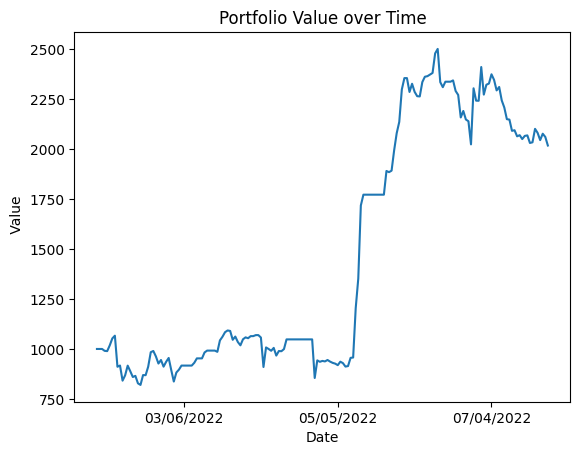

In [3]:
# Get daily data
daily = backtest.iloc[0::1440, :] # select every 1440'th row (because there are 1440 minutes in a day)

# Define x-axis
x_axis = pd.date_range(start="2022-01-31", end="2022-07-26", freq="D")

# Plot daily portfolio value
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.plot(x_axis, daily["balance"])
plt.title("Portfolio Value over Time")
plt.xlabel("Date")
plt.ylabel(" Value")
plt.show()

---

## Sharpe Ratio

The Sharpe ratio evaluates the relationship between risk assumed and return for an asset. It is defined as

$$
\text{Sharpe Ratio} = \frac{\text{Mean portfolio return} - \text{Risk-free rate}}{\text{Standard deviation of portfolio returns}}
$$

Let's compute the annualized Sharpe ratio of the backtest. It is defined as:

$$
\text{Annualized Sharpe Ratio} = \frac{\text{Average daily return} - \text{Risk-free rate}}{\text{Standard deviation of daily returns}} * \sqrt{\text{Number of days}}
$$

Here I will assume a risk-free rate of $0\%$. The Sharpe ratio is computed below:

In [4]:
# Get daily returns
daily_returns = daily['balance'].pct_change()

# Define risk-free rate
risk_free_rate = 0

# Compute Sharpe
sharpe = (np.mean(daily_returns) - risk_free_rate) / np.std(daily_returns) * np.sqrt(len(daily_returns))
print(sharpe)

1.441061697046876


---

## Distribution of Returns

Using the seaborn package, we can plot the distribution of daily returns returns:

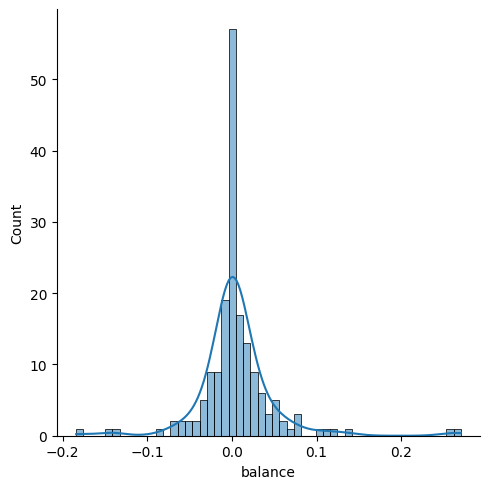

In [5]:
q25, q75 = np.nanpercentile(daily_returns, [25, 75])
bin_width = 2 * (q75 - q25) * len(daily_returns) ** (-1/3)
bins = round((daily_returns.max() - daily_returns.min()) / bin_width)

sns.displot(daily_returns, bins=bins, kde=True)